![Architecture](./figures/LSTM_Cell.svg)

\begin{gather*}
i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
h_t =o_t \odot \tanh(c_t) \\
\end{gather*}

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics

import os
import math
import numpy as np
import pandas as pd
from scipy.stats import norm

In [2]:
import mlflow
from mlflow.models import infer_signature
from mlflow.data.sources import LocalArtifactDatasetSource

import seaborn as sns
from tqdm.notebook import tqdm, trange

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

LOOKBACK = 5
HORIZON = 1
NUM_FACTORS = 1

LEARNING_RATE = 0.01
BATCH_SIZE = 64
NUM_EPOCHS = 50
LR_DECAY = 0.1
PATIENCE = 4
MIN_DELTA = 1e-5

HIDDEN_SIZE = 32
NUM_LAYERS = 2
DROPOUT = 0

In [4]:
sns.set_theme('paper', rc={'figure.figsize': (16, 4)})

torch.manual_seed(42)

mlflow.set_experiment("Stock Market Predictions")
mlflow.start_run(run_name="LSTM")
params = {
    'lookback': LOOKBACK,
    'horizon': HORIZON,
    'num_factors': NUM_FACTORS,
    'num_epochs': NUM_EPOCHS,
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'patience': PATIENCE,
    'lr_decay': LR_DECAY,
    'min_delta': MIN_DELTA,
    'input_size': LOOKBACK,
    'hidden_size': HIDDEN_SIZE,
    'num_layers': NUM_LAYERS,
    'dropout': DROPOUT
}

mlflow.log_params(params)

In [5]:
DATA_FILE = '../data/SSEC.csv'
df = pd.read_csv(DATA_FILE, index_col='Date')
data = df['Close'].values

mlflow.log_input(mlflow.data.from_pandas(df[['Close']], LocalArtifactDatasetSource(DATA_FILE), name=os.path.basename(DATA_FILE)))

In [6]:
train_size = int(0.7*len(data))
val_size = int(0.15*len(data))
test_size = len(data) - train_size - val_size

mlflow.log_param('train_size', train_size)
mlflow.log_param('val_size', val_size)
mlflow.log_param('test_size', test_size)

data_train = df.loc['2011-01-01':'2020-12-31']['Close'].values
data_val = df.loc['2021-01-01':'2021-12-31']['Close'].values
data_test = df.loc['2022-01-01':]['Close'].values

In [7]:
data_train.shape, data_val.shape, data_test.shape

((2432,), (243,), (242,))

In [8]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))

data_train = torch.FloatTensor(scaler.fit_transform(data_train.reshape(-1, NUM_FACTORS))).to(DEVICE)
data_val = torch.FloatTensor(scaler.transform(data_val.reshape(-1, NUM_FACTORS))).to(DEVICE)
data_test = torch.FloatTensor(scaler.transform(data_test.reshape(-1, NUM_FACTORS))).to(DEVICE)

In [9]:
# Create the sequences, assuming first column is the target
X_train = data_train.unfold(dimension=0, size=LOOKBACK, step=1)[:-HORIZON].transpose(-1,1)
y_train = data_train[:,0].unfold(dimension=0, size=HORIZON, step=1)[LOOKBACK:].transpose(-1,1)

X_val = data_val.unfold(dimension=0, size=LOOKBACK, step=1)[:-HORIZON].transpose(-1,1)
y_val = data_val[:,0].unfold(dimension=0, size=HORIZON, step=1)[LOOKBACK:].transpose(-1,1)

X_test = data_test.unfold(dimension=0, size=LOOKBACK, step=1)[:-HORIZON].transpose(-1,1)
y_test = data_test[:,0].unfold(dimension=0, size=HORIZON, step=1)[LOOKBACK:].transpose(-1,1)

\begin{gather*}
L = \textrm{sequence length} = \textrm{lookback} \\
H_{in} = \textrm{input\_size} = \textrm{num\_factors} \\
H_{out} = \textrm{output\_size} = \textrm{horizon} \\
X \sim (N,L,H_{in}),\ y \sim (N,H_{out})
\end{gather*}

In [10]:
X_train.size(), y_train.size(), X_val.size(), y_val.size(), X_test.size(), y_test.size()

(torch.Size([2427, 5, 1]),
 torch.Size([2427, 1]),
 torch.Size([238, 5, 1]),
 torch.Size([238, 1]),
 torch.Size([237, 5, 1]),
 torch.Size([237, 1]))

In [11]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=1, num_layers=1, output_size=1, dropout=0):
        super(LSTMModel, self).__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [13]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def __call__(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [14]:
model = LSTMModel(NUM_FACTORS, HIDDEN_SIZE, NUM_LAYERS, HORIZON, DROPOUT).to(DEVICE)
criterion = nn.MSELoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)

mlflow.log_param('criterion', type(criterion).__name__)
mlflow.log_param('optimizer', type(optimizer).__name__)

'Adam'

In [15]:
metric = nn.L1Loss().to(DEVICE)
mlflow.log_param('metric', type(metric).__name__)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=LR_DECAY, patience=PATIENCE)
mlflow.log_param('scheduler', type(scheduler).__name__)

early_stopper = EarlyStopper(patience=PATIENCE, min_delta=MIN_DELTA)

In [ ]:
def run_training(
    model: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    num_epochs: int,
    metric: torch.nn.Module = None,
    scheduler: torch.optim.lr_scheduler.LRScheduler = None,
    early_stopper: EarlyStopper = None,
):
    
    train_losses = []
    val_losses = []
    
    out_pbar = trange(num_epochs, unit='epoch')
    train_pbar = tqdm(total=len(train_loader), unit='batch')
    val_pbar = tqdm(total=len(val_loader), unit='batch')
    
    for epoch in out_pbar:
        try:
            out_pbar.set_description(f"Epoch:{epoch+1}/{num_epochs}" + (f" Best Validation Metric: {early_stopper.min_validation_loss:.5f}\r" if early_stopper else ''), refresh=True)
    
            # Training        
            model.train()
            epoch_train_loss = 0.0
            train_pbar.reset()
            for X, y in train_loader:
                train_pbar.update()
                    
                output = model(X)
                
                loss = criterion(output, y)
                loss.backward()
                            
                optimizer.step()
                optimizer.zero_grad()
                
                epoch_train_loss += loss.item()               
                train_pbar.set_description(f"Current training loss: {loss.item():.5f}", refresh=True)
                
            epoch_train_loss /= len(train_loader)
            train_losses.append(epoch_train_loss)
            train_pbar.set_description(f"Total training loss: {epoch_train_loss:.5f}", refresh=True)
            mlflow.log_metric('train_loss', epoch_train_loss, step=epoch+1)
            if scheduler:
                scheduler.step(epoch_train_loss)
            
            
            if (epoch+1) % (num_epochs/100) != 0:
                continue
            
            # Validation        
            model.eval()
            val_pbar.reset()
            
            epoch_val_loss = 0.0
            epoch_val_metric = 0.0
            for X, y in val_loader:
                val_pbar.update()
                                        
                output = model(X)
                
                loss = criterion(output, y)
                epoch_val_loss += loss.item()
                
                if metric:
                    val_metric = metric(output, y)
                    epoch_val_metric += val_metric.item()
                
                val_pbar.set_description(f"Current validation loss: {loss.item():.5f}", refresh=True)
                
            epoch_val_loss /= len(val_loader)
            val_losses.append(epoch_val_loss)
            val_pbar.set_description(f"Total validation loss: {epoch_val_loss:.5f}", refresh=True)
            mlflow.log_metric('val_loss', epoch_val_loss, step=epoch+1)
            
            if metric:
                epoch_val_metric /= len(val_loader)
                mlflow.log_metric('val_metric', epoch_val_loss, step=epoch+1)
                
            if early_stopper and epoch_val_loss < early_stopper.min_validation_loss:                             
                torch.save(model.state_dict(), f'../models/{type(model).__name__}.pt')
                mlflow.log_metric('val_loss_best', early_stopper.min_validation_loss, step=epoch)
                            
            if early_stopper and early_stopper(epoch_val_loss):
                print(f"Early stopping at epoch {epoch+1}")
                mlflow.log_metric('early_stop_epoch', epoch+1)
                break
        except KeyboardInterrupt:
            print(f"Interrupt at epoch {epoch+1}")
            mlflow.log_metric('early_stop_epoch', epoch+1)
            break
    
    train_pbar.close()
    val_pbar.close()

    return train_losses, val_losses

In [17]:
train_losses, val_losses = run_training(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    NUM_EPOCHS,
    metric,
    scheduler,
    early_stopper
)

  0%|          | 0/50 [00:00<?, ?epoch/s]

  0%|          | 0/38 [00:00<?, ?batch/s]

  0%|          | 0/4 [00:00<?, ?batch/s]

Early stopping at epoch 24


<Axes: title={'center': 'Losses'}>

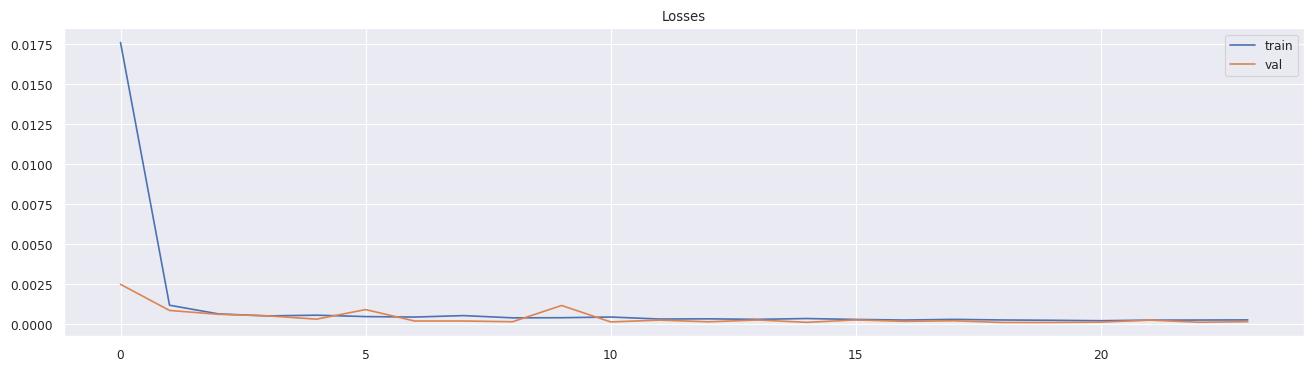

In [18]:
pd.DataFrame(data={'train': train_losses[::len(train_losses)//len(val_losses)], 'val': val_losses}).plot(title='Losses')

Registered model 'LSTM' already exists. Creating a new version of this model...
2025/03/08 13:43:31 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM, version 29
Created version '29' of model 'LSTM'.


<Axes: xlabel='Date'>

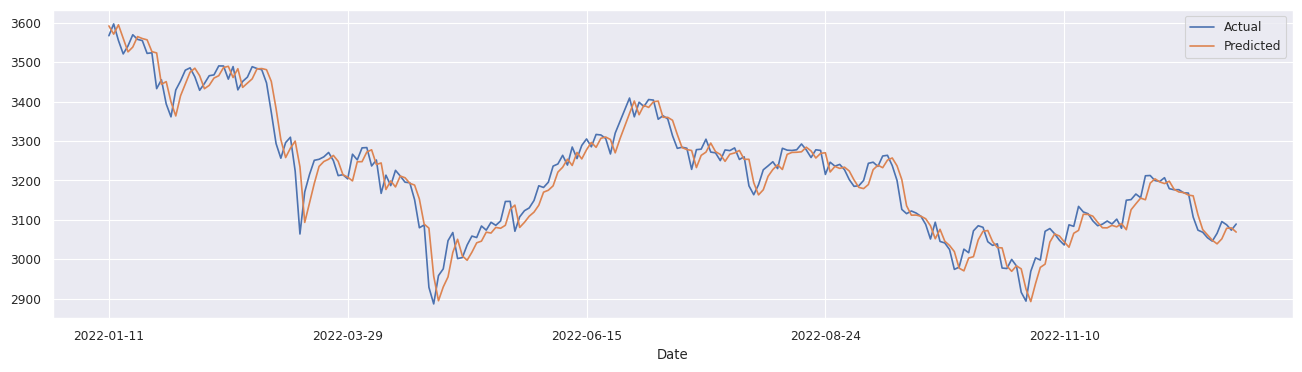

In [19]:
if os.path.exists(f'../models/{type(model).__name__}.pt'):    
    model.load_state_dict(torch.load(f"../models/{type(model).__name__}.pt"))
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

y_pred_inv = scaler.inverse_transform(y_pred.cpu().detach().numpy())[:,0]
y_test_inv = scaler.inverse_transform(y_test.cpu().detach().numpy())[:,0]

mlflow.pytorch.log_model(
    registered_model_name="LSTM",
    artifact_path="LSTM",
    pytorch_model=model,
    input_example=X_test.cpu().detach().numpy(),
    signature=infer_signature(X_test.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
)

pd.DataFrame([y_test_inv, y_pred_inv], index=['Actual', 'Predicted'], columns=df.index[-len(X_test):]).T.plot()

In [20]:
# Calculate MAE, MSE, and RMSE
mae = metrics.mean_absolute_error(y_pred_inv, y_test_inv)
mse = metrics.mean_squared_error(y_pred_inv, y_test_inv)
rmse = metrics.mean_squared_error(y_pred_inv, y_test_inv) ** 0.5

# Log the metrics to mlflow
mlflow.log_metric('test_mae', mae)
mlflow.log_metric('test_mse', mse)
mlflow.log_metric('test_rmse', rmse)

print(f"Test MAE: {mae:.4f}  Test MSE: {mse:.4f} Test RMSE: {rmse:.4f}")

Test MAE: 28.2067  Test MSE: 1420.0944 Test RMSE: 37.6841


<Axes: xlabel='Date'>

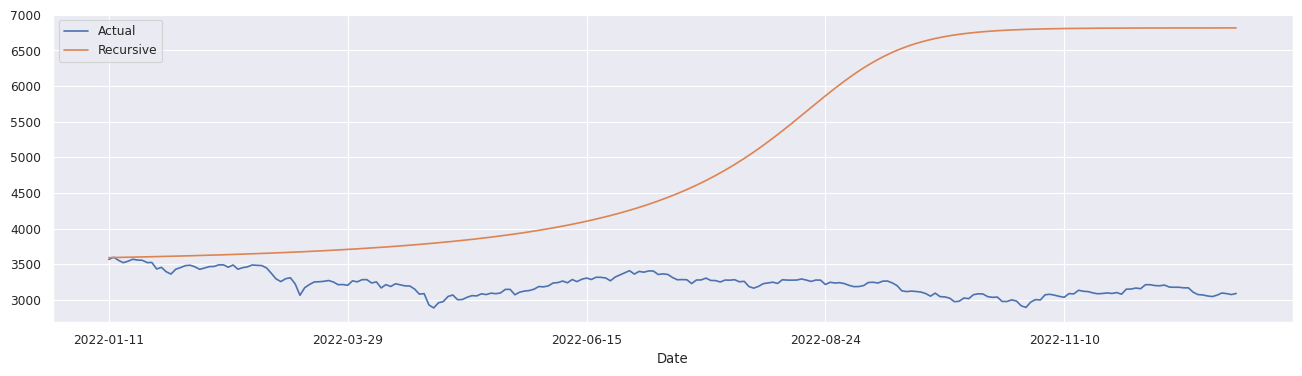

In [21]:
assert NUM_FACTORS == 1, "Recursive prediction only works with a single factor"
model.eval()
y_recursive = []

# Start with the first element of X_test
current_input = X_test[0].unsqueeze(0)

with torch.no_grad():
    for _ in range(len(X_test)):
        output = model(current_input).unsqueeze(-1)
        y_recursive.append(output[:,[0],:].cpu().numpy())

        # Prepare the next input by appending the prediction to the current input and removing the oldest value
        current_input = torch.cat((current_input[:, 1:, :], output[:,[0],:]), dim=1)

y_recursive = np.concatenate(y_recursive, axis=1).squeeze()
y_recursive_inv = scaler.inverse_transform(y_recursive.reshape(-1, 1)).flatten()

pd.DataFrame([y_test_inv, y_recursive_inv], index=['Actual', 'Recursive'], columns=df.index[-len(X_test):]).T.plot()

In [22]:
assert NUM_FACTORS == 1, "Recursive prediction only works with a single factor"
# Calculate MAE, MSE, and RMSE
mae = metrics.mean_absolute_error(y_recursive_inv, y_test_inv)
mse = metrics.mean_squared_error(y_recursive_inv, y_test_inv)
rmse = metrics.mean_squared_error(y_recursive_inv, y_test_inv) ** 0.5

# Log the metrics to mlflow
mlflow.log_metric('test_mae_recursive', mae)
mlflow.log_metric('test_mse_recursive', mse)
mlflow.log_metric('test_rmse_recursive', rmse)
mlflow.end_run()

print(f"Recursive MAE: {mae:.4f} Recursive MSE: {mse:.4f} Recursive RMSE: {rmse:.4f}")

🏃 View run LSTM at: http://172.18.0.2:5000/#/experiments/689077898730888678/runs/e77e9999afd249d6b07ce5e6f1b1aae1
🧪 View experiment at: http://172.18.0.2:5000/#/experiments/689077898730888678
Recursive MAE: 1818.2949 Recursive MSE: 5339934.0000 Recursive RMSE: 2310.8297


<Axes: xlabel='Date'>

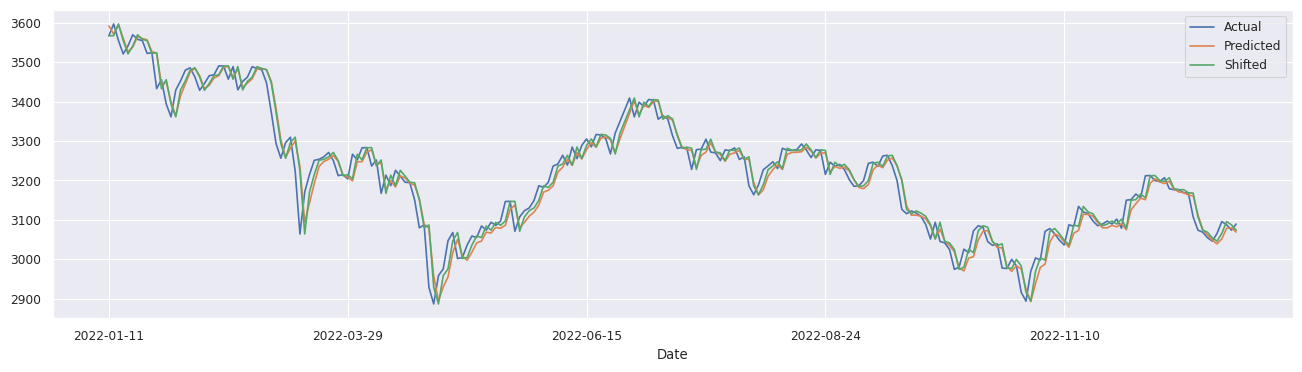

In [23]:
#Compare to the naive forecast
shifted_y_test_inv = np.roll(y_test_inv, 1).flatten()
shifted_y_test_inv[0] = y_test_inv[0]

pd.DataFrame([y_test_inv, y_pred_inv, shifted_y_test_inv], index=['Actual', 'Predicted', 'Shifted'], columns=df.index[-len(X_test):]).T.plot()

In [24]:
# Naive predictions
mae = metrics.mean_absolute_error(shifted_y_test_inv, y_test_inv)
mse = metrics.mean_squared_error(shifted_y_test_inv, y_test_inv)
rmse = metrics.mean_squared_error(shifted_y_test_inv, y_test_inv) ** 0.5

print(f"Naive MAE: {mae:.4f}  Naive MSE: {mse:.4f} Naive RMSE: {rmse:.4f}")

Naive MAE: 26.2390  Naive MSE: 1307.3947 Naive RMSE: 36.1579


<Axes: xlabel='Date'>

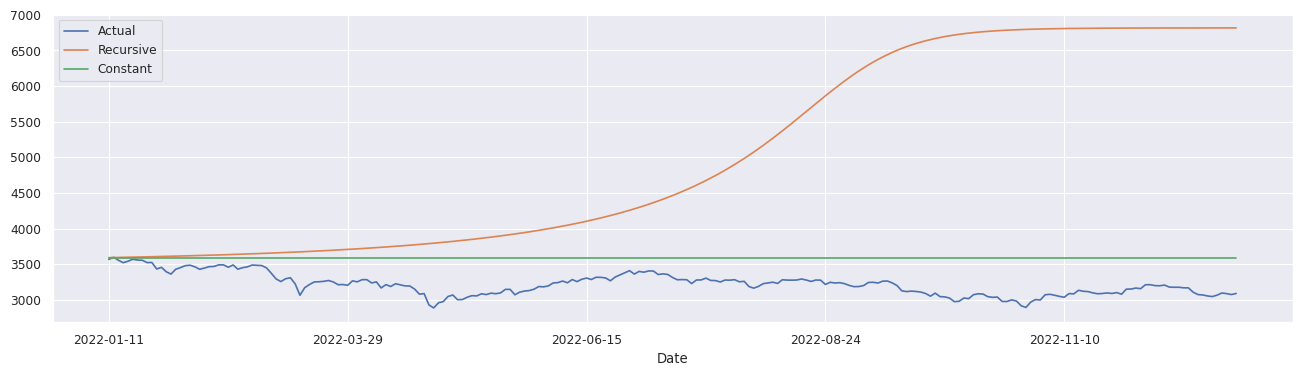

In [25]:
const_pred_inv = np.full_like(y_test_inv.flatten(), scaler.inverse_transform(X_test[0].cpu().numpy().flatten().reshape(-1, 1))[-1][0])

pd.DataFrame([y_test_inv, y_recursive_inv, const_pred_inv], index=['Actual', 'Recursive', 'Constant'], columns=df.index[-len(X_test):]).T.plot()

In [26]:
# Constant prediction
mae = metrics.mean_absolute_error(const_pred_inv, y_test_inv)
mse = metrics.mean_squared_error(const_pred_inv, y_test_inv)
rmse = metrics.mean_squared_error(const_pred_inv, y_test_inv) ** 0.5

print(f"Constant MAE: {mae:.4f} Constant MSE: {mse:.4f} Constant RMSE: {rmse:.4f}")

Constant MAE: 375.8393 Constant MSE: 164288.3906 Constant RMSE: 405.3250


<Axes: xlabel='Date'>

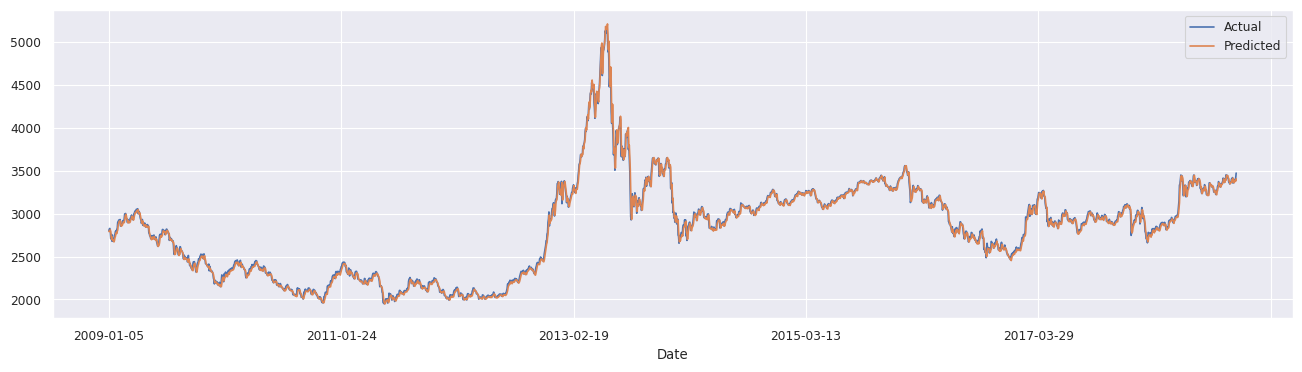

In [27]:
# Get predictions on the training dataset to check for overfitting
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train)

y_train_pred_inv = scaler.inverse_transform(y_train_pred.cpu().detach().numpy())[:,0]
y_train_inv = scaler.inverse_transform(y_train.cpu().detach().numpy())[:,0]

pd.DataFrame([y_train_inv, y_train_pred_inv], index=['Actual', 'Predicted'], columns=df.index[:len(X_train)]).T.plot()

In [28]:
# Evaluate the model on the training dataset
mae = metrics.mean_absolute_error(y_train_pred_inv, y_train_inv)
mse = metrics.mean_squared_error(y_train_pred_inv, y_train_inv)
rmse = metrics.mean_squared_error(y_train_pred_inv, y_train_inv) ** 0.5

print(f"Train MAE: {mae:.4f} Train MSE: {mse:.4f} Train RMSE: {rmse:.4f}")

Train MAE: 29.9260 Train MSE: 2085.2056 Train RMSE: 45.6641
